<a href="https://colab.research.google.com/github/GeenDutchman/cs474_labs/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 30% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**



**DONE:**

* Watch tutorial

In [100]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt 
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [102]:
from torch.nn.parameter import Parameter
import pdb

In [103]:
class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean'):
    super(CrossEntropyLoss, self).__init__()
    self.loss = nn.LogSoftmax()
  
  def forward(self, prediction, target):
    pred = F.log_softmax(prediction, dim = -1)
    return F.nll_loss(pred, target)



class Conv2d(nn.Module):
  def __init__(self, n_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, init='uniform'):
    self.__dict__.update(locals()) # debatable
    super(Conv2d, self).__init__()

    # (out, in, k, k)
    self.weight = Parameter(torch.Tensor(self.out_channels,
                               self.n_channels,
                               *kernel_size))
    self.bias = Parameter(torch.Tensor(self.out_channels))
    # print(self.weight.data.dtype)

    # initialize weights and bias
    if init is 'uniform':
      self._uniform_init()
    elif init is 'xe':
      self._xe_init()
    elif init is 'orthogonal':
      self._orthogonal_init()
    else:
      raise 'Bad init option'

    self.bias.data.uniform_(0, 0)


  def _uniform_init(self):
    self.weight.data.uniform_(-1,1)

  def _multiply_kernel(self):
    product = 1
    for num in self.kernel_size:
      product *= num
    return product

  def _xe_init(self):
    print('xe')
    # normal takes a standard deviation as the 'scale' argument.  1/(n_channel*kernel_size) is the variance
    # for a normal/gaussian distribution, the square of the stddev is variance
    variance = 1/(self.n_channels*self._multiply_kernel())
    x = np.random.normal(scale=np.sqrt(variance), size=(self.out_channels, self.n_channels, *self.kernel_size)).astype(np.float32)
    self.weight = Parameter(torch.from_numpy(x))

  def _orthogonal_init(self):
    print('ortho')

    kernel_product = self._multiply_kernel()

    x = np.random.random((self.out_channels, self.n_channels * kernel_product)).astype(np.float32)
    if self.out_channels > self.n_channels * kernel_product:
      x = x.T
    U, _, Vt = np.linalg.svd(x, full_matrices=False)

    # np.allclose(np.dot(Vt, Vt.T), np.eye(Vt.shape[0]))
    w = Vt.reshape(self.out_channels, self.n_channels, *self.kernel_size)
    self.weight = Parameter(torch.from_numpy(w))
    # print(self.weight.data.dtype)
    # print('temporary')

  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, self.padding,
                    self.dilation, self.groups)
  


In [104]:
class ConvNetwork(nn.Module):
  def __init__(self, dataset):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 10

    self.net = nn.Sequential(Conv2d(c, 10, (3, 3), padding=(1,1), init='xe'),
                             nn.ReLU(),
                             Conv2d(10, output, (28, 28), padding=(0,0), init='orthogonal'),
                             )
    
  def forward(self, x):
    #n, c, h, w = x.size()
    return self.net(x).squeeze(2).squeeze(2)


In [105]:
# Use the dataset class you created in lab2
class LinearNetwork(nn.Module):
  def __init__(self, dataset):
    super(LinearNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    out_dim = 10 # hardcoded

    self.net = nn.Sequential(nn.Linear(c * h * w, 1000),
                             nn.ReLU(),
                             nn.Linear(1000, out_dim))
    
  def forward(self, x):
    n, c, h, w = x.size()
    flattened = x.view(n, c * h * w)
    return self.net(flattened)


class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, train=train, transform=transforms.ToTensor(), download=True)

  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y

  def __len__(self):
    return len(self.data)

In [106]:
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)
model = ConvNetwork(train_dataset)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
objective = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)
validation_loader = DataLoader(val_dataset, batch_size=42, pin_memory=True)



xe
ortho


In [107]:
validations = []
losses = []

num_epochs = 1
update_epoch = 100
for epoch in range(num_epochs):
  loop = tqdm(total=len(train_loader) * num_epochs, position=0)

  for batch, (x, y_truth) in enumerate(train_loader):
    # learn
    x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)
    
    optimizer.zero_grad()

    y_hat = model(x)
    loss = objective(y_hat, y_truth)

    loss.backward()
    losses.append(loss.item())
    accuracy = 0 # TODO: we do ourself
    loop.set_description('epoch:{} loss:{:.4f} accuracy:{:.3f}'.format(epoch, loss.item(), accuracy))
    loop.update(1)

    optimizer.step()

    if batch % update_epoch == 0:
      val = np.mean([objective(model(x.cuda()), y.cuda()).item() for x, y in validation_loader])
      validations.append((len(losses), val))

  loop.close()



epoch:0 loss:0.4541 accuracy:0.000: 100%|██████████| 1429/1429 [00:25<00:00, 55.57it/s]


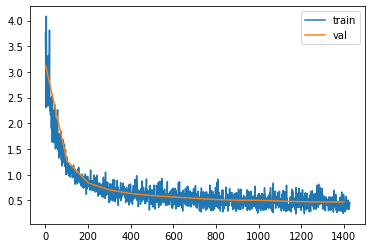

In [108]:
## plot

a, b = zip(*validations)
plt.plot(losses, label='train')
plt.plot(a, b, label='val')
plt.legend()
plt.show()

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**

 

**DONE:**

* CrossEntropyLoss
* Conv2D

___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**

**DONE:**
* Parameterize custom Conv2D for different initilization strategies
* Uniform
* Orthogonal
* Xe







___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time
* Print out number of parameters in the model 

**DONE:**


In [109]:

# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy



In [110]:
# Compute and print the number of parameters in the model


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **Your answer in bold here**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**

**TODO:**

* Answer all the questions above 

**DONE:**


In [111]:
# Write some test code for checking the answers for these problems (example shown in the video)
